##RegresstionSNR on Lorawan

> เพิ่มข้อความทั้งย่อหน้าที่ยกมา



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


**Preparedata for analysis**

In [ ]:
def prepare_and_save_data():
    # Load raw datasets
    df_soil = pd.read_csv("/content/drive/My Drive/ClimateData/sensors_data.csv", sep=";")
    df_air = pd.read_csv("/content/drive/My Drive/ClimateData/weather_data.csv", sep=";")

    # Distance info
    dist = [
        ['tinovi-01', 40], ['tinovi-02', 16], ['tinovi-03', 330],
        ['tinovi-04', 240], ['tinovi-05', 90], ['tinovi-06', 65],
        ['tinovi-07', 170], ['tinovi-08', 340]
    ]
    dfdist = pd.DataFrame(dist, columns=['nodeid', 'distance'])

    # Prepare for asof merge
    df_soil = df_soil.sort_values('timestamp')
    df_air = df_air.sort_values('Timestamp')

    # Merge asof (nearest)
    df_soil.rename(columns={'timestamp': 'Timestamp'}, inplace=True)
    merged_df = pd.merge_asof(df_soil, df_air, on='Timestamp', direction='nearest', tolerance=300)

    # Merge distance info
    merged_df = merged_df.merge(dfdist, how='left', on='nodeid')

    # Drop unwanted columns
    if 'spreading_factor' in merged_df.columns:
        merged_df.drop(columns=['spreading_factor'], inplace=True)

    # Drop rows with missing in key columns only
    merged_df = merged_df.dropna(subset=['gtw_snr', 'frequency'])

    # Save processed CSV
    save_path = "/content/drive/My Drive/ClimateData/dftobeloaded.csv"
    merged_df.to_csv(save_path, index=False)
    print(f"Saved processed data to: {save_path}")
    print(f"Final dataset shape: {merged_df.shape}")

if __name__ == '__main__':
    prepare_and_save_data()


Saved processed data to: /content/drive/My Drive/ClimateData/dftobeloaded.csv
Final dataset shape: (190503, 18)


In [ ]:
#ตรวจดูข้อมูล
import pandas as pd
def get_df():
  df = pd.read_csv("/content/drive/My Drive/ClimateData/dftobeloaded.csv", sep=",")
  return df
print(df)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190503 entries, 0 to 190502
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           190503 non-null  int64  
 1   nodeid       190503 non-null  object 
 2   timestamp    190503 non-null  int64  
 3   battery      190503 non-null  int64  
 4   frequency    190503 non-null  float64
 5   data_rate    190503 non-null  object 
 6   coding_rate  190503 non-null  object 
 7   gtw_id       190503 non-null  object 
 8   gtw_channel  190503 non-null  int64  
 9   gtw_rssi     190503 non-null  int64  
 10  gtw_snr      190503 non-null  float64
 11  soil_temp    190502 non-null  float64
 12  soil_hum     190502 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 18.9+ MB


In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# ตรวจสอบข้อมูลที่หายไปหรือมีค่าที่ไม่เหมาะสม
missing_data = df.isnull().sum()
print("Missing data:")
print(missing_data)

# ลบแถวที่มีข้อมูลที่หายไป
df = df.dropna()

# ลบข้อมูลที่ซ้ำกัน
df = df.drop_duplicates()

Missing data:
Unnamed: 0            0
id                    0
nodeid                0
Timestamp_x           0
battery               0
frequency             0
data_rate             0
coding_rate           0
gtw_id                0
gtw_channel           0
gtw_rssi              0
gtw_snr               0
soil_temp             0
soil_hum              0
assigned_timestamp    0
Timestamp_y           0
Temp                  0
Hum                   0
Bar                   0
Rain                  0
distance              0
dtype: int64


In [ ]:
#ReCheckข้อมูล
df = get_df()
print(df)

            id     nodeid   Timestamp  battery  frequency data_rate  \
0            1  tinovi-06  1605522681       96      868.1  SF7BW125   
1            2  tinovi-03  1605522697       99      868.1  SF7BW125   
2            3  tinovi-05  1605522723      107      868.1  SF7BW125   
3            4  tinovi-02  1605522759      109      868.3  SF7BW125   
4            5  tinovi-07  1605522764      100      868.1  SF7BW125   
...        ...        ...         ...      ...        ...       ...   
190498  190499  tinovi-02  1612878483       95      867.7  SF7BW125   
190499  190500  tinovi-05  1612878494       93      867.1  SF7BW125   
190500  190501  tinovi-01  1612878508       87      867.9  SF7BW125   
190501  190502  tinovi-04  1612878607       87      867.3  SF7BW125   
190502  190503  tinovi-03  1612878628       87      867.5  SF7BW125   

       coding_rate                gtw_id  gtw_channel  gtw_rssi  gtw_snr  \
0              4/5  eui-3133303739005600            0       -64     9.5

In [ ]:
df.describe().T r

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,190502.0,9.525087e+04,5.499374e+04,0.000000e+00,4.762525e+04,9.525050e+04,1.428768e+05,1.905020e+05
id,190502.0,9.525151e+04,5.499336e+04,1.000000e+00,4.762625e+04,9.525150e+04,1.428768e+05,1.905030e+05
Timestamp_x,190502.0,1.609234e+09,2.107565e+06,1.605523e+09,1.607419e+09,1.609234e+09,1.611063e+09,1.612879e+09
battery,190502.0,9.506062e+01,5.593005e+00,8.200000e+01,9.100000e+01,9.500000e+01,9.900000e+01,1.440000e+02
frequency,190502.0,8.678001e+02,4.583412e-01,8.671000e+02,8.673500e+02,8.679000e+02,8.683000e+02,8.685000e+02
gtw_channel,190502.0,3.500058e+00,2.290932e+00,0.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00
gtw_rssi,190502.0,-6.998829e+01,9.804444e+00,-1.080000e+02,-7.800000e+01,-6.900000e+01,-6.200000e+01,-4.500000e+01
gtw_snr,190502.0,8.651338e+00,1.101983e+00,-9.000000e+00,7.750000e+00,9.000000e+00,9.500000e+00,1.175000e+01
soil_temp,190502.0,5.184519e+00,2.428138e+00,4.600000e-01,3.310000e+00,5.130000e+00,6.740000e+00,2.265000e+01
soil_hum,190502.0,7.619241e+01,1.740106e+01,1.110000e+00,6.842000e+01,7.703000e+01,9.064000e+01,9.718000e+01


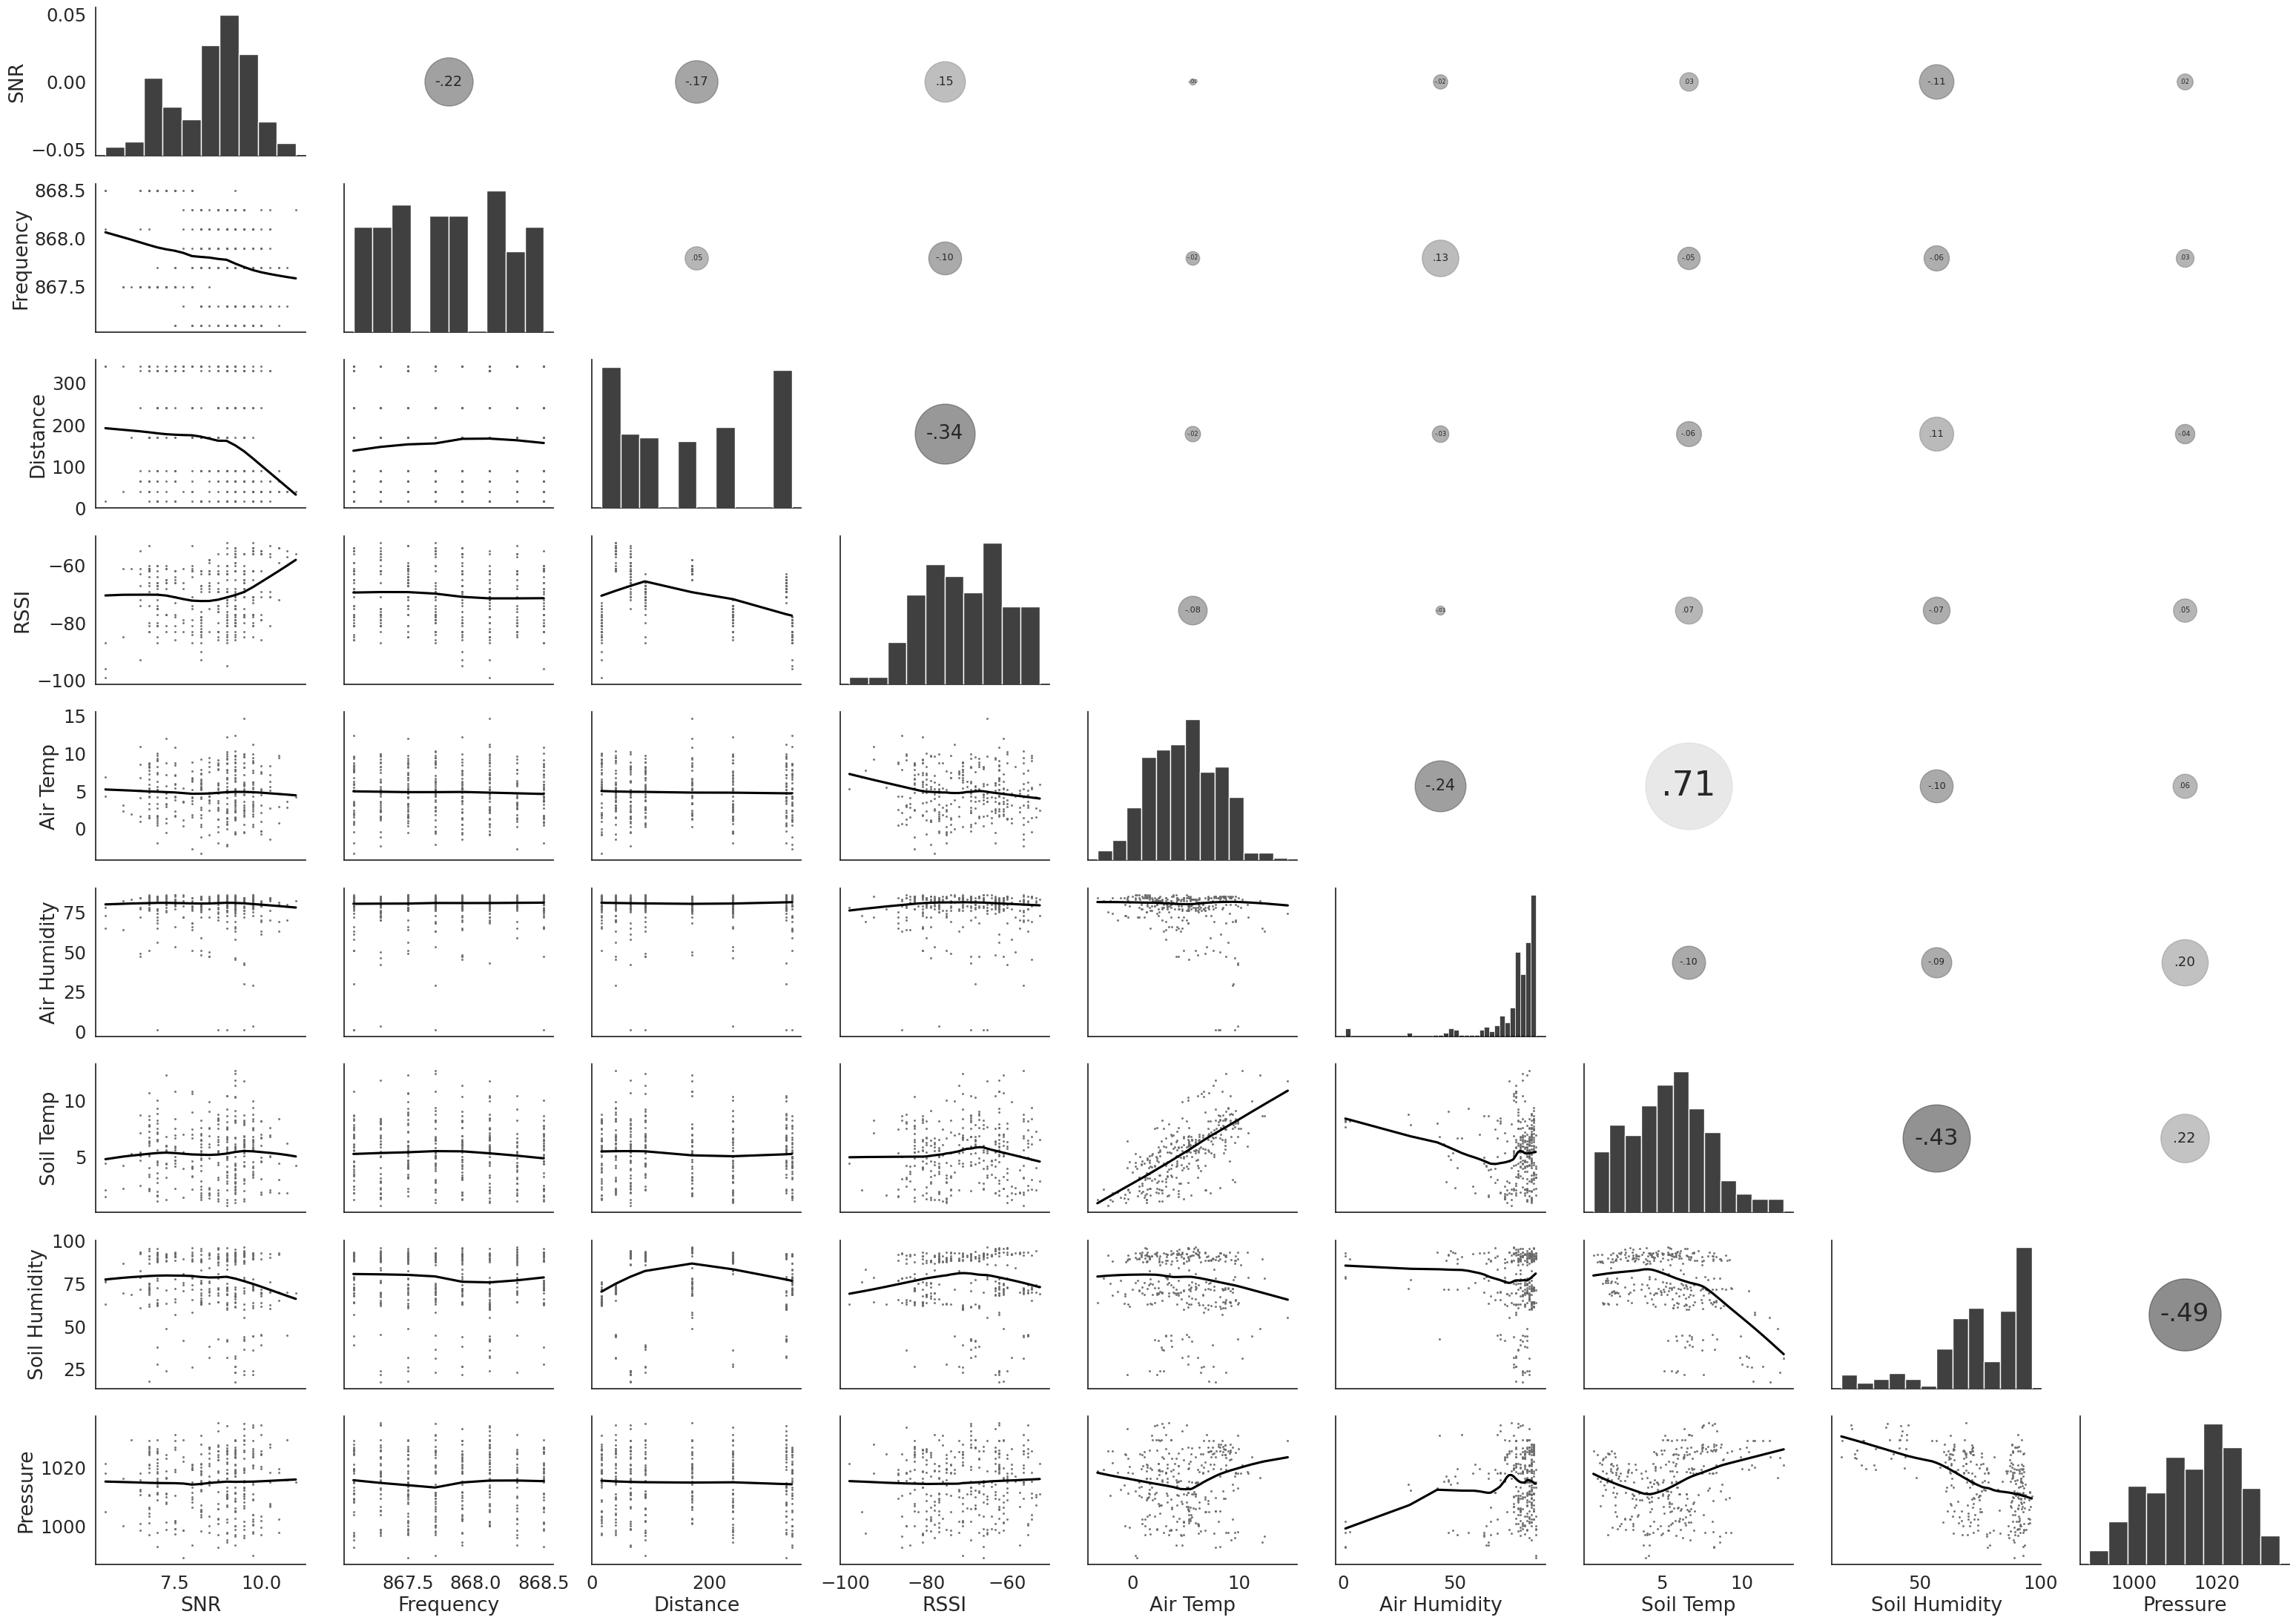

TypeError: plot_feature_importance() got an unexpected keyword argument 'save_path'

In [ ]:

# โหลดข้อมูล
df = pd.read_csv("/content/drive/My Drive/ClimateData/dftobeloaded.csv")

# สร้างชุดฟีเจอร์
feature_sets = generate_feature_sets(df)

# สรุปความสัมพันธ์
plot_correlation_pairgrid(
    df,
    columns=['gtw_snr','frequency','distance','gtw_rssi','Temp','Hum','soil_temp','soil_hum','Bar'],
    labels=['SNR','Frequency','Distance','RSSI','Air Temp','Air Humidity','Soil Temp','Soil Humidity','Pressure'],
    save_path="/content/drive/My Drive/ClimateData/correlation_plot.png"
)

# สมมติว่ามี importance_dict จากโมเดล
importance_dict = {
    'frequency': 0.3,
    'gtw_rssi': 0.2,
    'soil_temp': 0.15,
    'soil_hum': 0.1,
    'Temp': 0.1,
    'Hum': 0.05,
    'Bar': 0.05,
    'distance': 0.05
}

# วาดแผนภูมิสรุปความสำคัญฟีเจอร์
plot_feature_importance(importance_dict, save_path="/content/drive/My Drive/ClimateData/feature_importance.png")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")


def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df.dropna()
    if 'spreading_factor' in df.columns:
        df = df.drop(columns=['spreading_factor'])
    return df


def get_model(name):
    if name == 'Random Forest':
        return RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    elif name == 'XGBoost':
        return XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=42)
    elif name == 'Gradient Boosting':
        return GradientBoostingRegressor(n_estimators=100, random_state=42)
    elif name == 'CatBoost':
        return CatBoostRegressor(depth=10, iterations=1000, learning_rate=0.05, random_seed=42, silent=True)
    elif name == 'Decision Tree':
        return DecisionTreeRegressor(max_depth=10, random_state=42)
    elif name == 'Linear Regression':
        return LinearRegression()
    elif name == 'SVM':
        return SVR(cache_size=20000)
    else:
        raise ValueError(f"Model name '{name}' not recognized.")


def get_pov(predictions, actual):
    ss_res = np.sum((actual - predictions) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    pov = 1 - (ss_res / ss_tot)
    return pov


def get_rmse(pred, actual):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    return rmse


def run_simulation(df, feature_list, target, model_name):
    X = df[feature_list]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    model = get_model(model_name)
    start = time.time()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    elapsed = time.time() - start

    rmse = get_rmse(predictions, y_test)
    r2 = r2_score(y_test, predictions)
    pov = get_pov(predictions, y_test)

    line = f"{'+'.join(feature_list)},{model_name},{pov},{rmse},{r2},{elapsed}\n"

    with open("/content/drive/My Drive/ClimateData/resSNR.txt", 'a') as fp:
        fp.write(line)

    print(f"Features: {feature_list} | Model: {model_name} | POV: {pov:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f} | Time: {elapsed:.2f}s")


def plot_model_comparison(result_path, save_dir="/content/drive/My Drive/ClimateData/graphs"):
    import os
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    df = pd.read_csv(result_path, header=None)
    df.columns = ['Features', 'Model', 'POV', 'RMSE', 'R2', 'Time']

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Model', y='RMSE', hue='Features', data=df)
    plt.xticks(rotation=45)
    plt.title('RMSE Comparison Across Models and Feature Sets')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "rmse_comparison.png"), dpi=300)
    plt.close()

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Model', y='R2', hue='Features', data=df)
    plt.xticks(rotation=45)
    plt.title('R² Comparison Across Models and Feature Sets')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "r2_comparison.png"), dpi=300)
    plt.close()

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Model', y='POV', hue='Features', data=df)
    plt.xticks(rotation=45)
    plt.title('POV Comparison Across Models and Feature Sets')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "pov_comparison.png"), dpi=300)
    plt.close()

    print(f"Graphs saved in: {save_dir}")


def main():
    df = load_data("/content/drive/My Drive/ClimateData/dftobeloaded.csv")

    testlist1 = [['frequency'], ['frequency', 'soil_temp', 'soil_hum'], ['frequency', 'Temp', 'Hum', 'Bar'],
                 ['frequency', 'Temp', 'Hum', 'soil_temp', 'soil_hum', 'Bar']]
    testlist2 = [['frequency', 'distance'], ['frequency', 'distance', 'soil_temp', 'soil_hum'],
                 ['frequency', 'distance', 'Temp', 'Hum', 'Bar'],
                 ['frequency', 'distance', 'Temp', 'Hum', 'soil_temp', 'soil_hum', 'Bar']]
    testlist3 = [['frequency', 'gtw_rssi'], ['frequency', 'gtw_rssi', 'soil_temp', 'soil_hum'],
                 ['frequency', 'gtw_rssi', 'Temp', 'Hum', 'Bar'],
                 ['frequency', 'gtw_rssi', 'Temp', 'Hum', 'soil_temp', 'soil_hum', 'Bar']]
    testlist4 = [['frequency', 'distance', 'gtw_rssi'], ['frequency', 'distance', 'gtw_rssi', 'soil_temp', 'soil_hum'],
                 ['frequency', 'distance', 'gtw_rssi', 'Temp', 'Hum', 'Bar'],
                 ['frequency', 'distance', 'gtw_rssi', 'Temp', 'Hum', 'soil_temp', 'soil_hum', 'Bar']]

    models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'Decision Tree', 'Linear Regression']

    import os
    try:
        os.remove("/content/drive/My Drive/ClimateData/resSNR.txt")
    except:
        pass

    for t in testlist1 + testlist2 + testlist3 + testlist4:
        for m in models:
            run_simulation(df, t, 'gtw_snr', m)

    plot_model_comparison("/content/drive/My Drive/ClimateData/resSNR.txt")


if __name__ == '__main__':
    main()


Features: ['frequency'] | Model: Random Forest | POV: 0.6544 | RMSE: 0.6482 | R2: 0.6544 | Time: 3.51s
Features: ['frequency'] | Model: Gradient Boosting | POV: 0.6544 | RMSE: 0.6482 | R2: 0.6544 | Time: 3.16s
Features: ['frequency'] | Model: XGBoost | POV: 0.6544 | RMSE: 0.6482 | R2: 0.6544 | Time: 1.47s
Features: ['frequency'] | Model: CatBoost | POV: 0.6544 | RMSE: 0.6482 | R2: 0.6544 | Time: 25.40s
Features: ['frequency'] | Model: Decision Tree | POV: 0.6544 | RMSE: 0.6482 | R2: 0.6544 | Time: 0.02s
Features: ['frequency'] | Model: Linear Regression | POV: 0.0430 | RMSE: 1.0787 | R2: 0.0430 | Time: 0.01s
Features: ['frequency', 'soil_temp', 'soil_hum'] | Model: Random Forest | POV: 0.6869 | RMSE: 0.6170 | R2: 0.6869 | Time: 25.24s
Features: ['frequency', 'soil_temp', 'soil_hum'] | Model: Gradient Boosting | POV: 0.6782 | RMSE: 0.6255 | R2: 0.6782 | Time: 11.85s
Features: ['frequency', 'soil_temp', 'soil_hum'] | Model: XGBoost | POV: 0.6850 | RMSE: 0.6189 | R2: 0.6850 | Time: 4.16s


In [ ]:
def run_simulation_return(df, feature_list, target, model_name):
    X = df[feature_list]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    model = get_model(model_name)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    return y_test.values, predictions


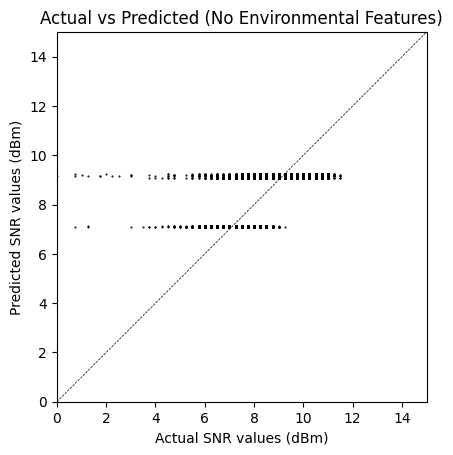

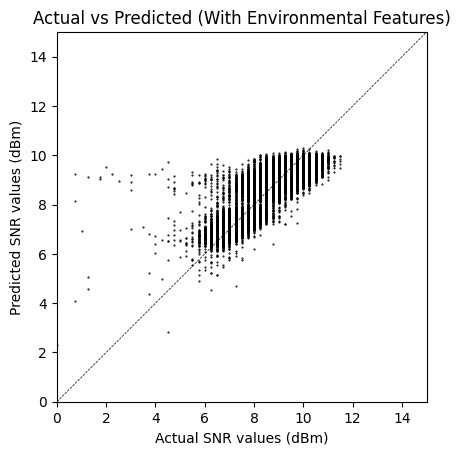

In [ ]:
import csv
import matplotlib.pyplot as plt

# โหลดข้อมูล (ถ้ายังไม่โหลด)
df = load_data("/content/drive/My Drive/ClimateData/dftobeloaded.csv")

fs = 10
models = ['XGBoost']

# ฟังก์ชันพล็อตกราฟและบันทึก
def plot_actual_vs_predicted(actual, predict, title, save_path=None):
    fig, ax = plt.subplots()
    ax.scatter(actual, predict, c='black', marker='.', s=1)
    ax.axline((0, 0), slope=1, linestyle='--', color='k', lw=0.5)
    ax.set_xlabel("Actual SNR values (dBm)", fontsize=fs)
    ax.set_ylabel("Predicted SNR values (dBm)", fontsize=fs)
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 15)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', labelsize=fs)
    plt.title(title)
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# ① ชุด features ไม่มีสิ่งแวดล้อม
testlist1 = [['frequency']]
for t in testlist1:
    for m in models:
        actual, predict = run_simulation_return(df, t, 'gtw_snr', m)

with open('/content/drive/My Drive/ClimateData/SNR_noEnvi.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(actual, predict))

plot_actual_vs_predicted(
    actual, predict,
    title='Actual vs Predicted (No Environmental Features)',
    save_path='/content/drive/My Drive/ClimateData/SNR_noEnvi_plot.png'
)

# ② ชุด features รวมสิ่งแวดล้อม
testlist2 = [['frequency', 'gtw_rssi', 'Temp', 'Hum', 'soil_temp', 'soil_hum', 'Bar']]
for t in testlist2:
    for m in models:
        actual, predict = run_simulation_return(df, t, 'gtw_snr', m)

with open('/content/drive/My Drive/ClimateData/SNR_withEnvi.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(actual, predict))

plot_actual_vs_predicted(
    actual, predict,
    title='Actual vs Predicted (With Environmental Features)',
    save_path='/content/drive/My Drive/ClimateData/SNR_withEnvi_plot.png'
)


In [ ]:
def summarize_and_plot_best(df_results, df):
    # หาโมเดลที่มี RMSE ต่ำที่สุด
    best_result = df_results.loc[df_results['RMSE'].idxmin()]

    best_features = best_result['features'].split('+')
    best_model_name = best_result['model']

    print("🔍 Best Model Summary")
    print("-----------------------------")
    print(f"Best Model : {best_model_name}")
    print(f"Features   : {', '.join(best_features)}")
    print(f"RMSE       : {best_result['RMSE']:.4f}")
    print(f"POV        : {best_result['POV']:.4f}")
    print(f"R² Score   : {best_result['R2']:.4f}")
    print(f"Train Time : {best_result['Train_Time(s)']:.2f} seconds")
    print("-----------------------------\n")

    # ฝึกโมเดลใหม่กับชุดฟีเจอร์ที่ดีที่สุดเพื่อวาดกราฟ
    X = df[best_features]
    y = df['gtw_snr']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    best_model = get_model(best_model_name)
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)

    if hasattr(best_model, 'feature_importances_'):
        plot_feature_importance(best_model, best_features, f"Feature Importance ({best_model_name})")

    plot_snr_scatter(y_test, predictions, f"Best Model SNR Prediction\n({best_model_name} with {', '.join(best_features)})")

def main():
    df, feature_cols = load_and_prepare_data("/content/drive/My Drive/ClimateData/dftobeloaded.csv")

    feature_sets = generate_feature_sets(df)
    print(f"ชุดฟีเจอร์ที่สร้างอัตโนมัติ: {len(feature_sets)} ชุด")

    models = ['XGBoost', 'Random Forest', 'CatBoost', 'Gradient Boosting', 'Linear Regression']

    df_results = run_experiment(df, feature_sets, models)
    df_results.to_csv("/content/drive/My Drive/ClimateData/model_results.csv", index=False)

    plot_summary(df_results)

    summarize_and_plot_best(df_results, df)  # เรียกแสดงสรุปและกราฟของโมเดล+ชุดฟีเจอร์ที่ดีที่สุด
